In [1]:
import re
import numpy as np
import pandas as pd
import string
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, Bidirectional, LSTM, Dropout, BatchNormalization, Masking
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.optimizers import Adam
from nltk.translate.bleu_score import sentence_bleu
import seaborn as sns
import nltk


# 라벨 데이터 작업
 - No Finding : 특이 점을 찾지 못한 경우
    - 반대의 경우는 특이 점을 찾은 경우 

In [2]:
label_data_path = './data/mimic-cxr-2.0.0-chexpert.csv'

label_data_csv = pd.read_csv(label_data_path)
# 필요 없는 피처 필터링
label_data_filter = label_data_csv.drop(columns=['subject_id', 'Support Devices'])

label_data_filter = label_data_filter.fillna(0)

label_data_noFinding = label_data_filter[['study_id', 'No Finding']]
label_data_noFinding['No Finding'] = label_data_noFinding['No Finding'].fillna(0)

label_data_noFinding['Finding'] = label_data_noFinding['No Finding'].apply(lambda x: 0 if x == 1 else 1)
label_data_Finding = label_data_noFinding[['study_id', 'Finding']]

label_data_Finding.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227827 entries, 0 to 227826
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   study_id  227827 non-null  int64
 1   Finding   227827 non-null  int64
dtypes: int64(2)
memory usage: 3.5 MB


C:\Users\Administrator\AppData\Local\Temp\ipykernel_4756\2816991744.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_data_noFinding['No Finding'] = label_data_noFinding['No Finding'].fillna(0)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_4756\2816991744.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_data_noFinding['Finding'] = label_data_noFinding['No Finding'].apply(lambda x: 0 if x == 1 else 1)


In [3]:
label_data_Finding.head()

,study_id,Finding
0,50414267,0
1,53189527,0
2,53911762,0
3,56699142,0
4,57375967,1


# null 값 확인 
 - 50%가 넘는 데이터가 남게 됨 (impression, findings)
 - 11,000 여개 정도의 데이터가 남게 되며 위를 학습시켜도 무난할 것이라 예상 

In [4]:
ehr_csv_data_path = './data/findings_and_impression.csv'

ehr_data_csv = pd.read_csv(ehr_csv_data_path)

cnt = 0
for i in range(len(ehr_data_csv)):
    if pd.isnull(ehr_data_csv['Findings'].iloc[i]) or pd.isnull(ehr_data_csv['Impression'].iloc[i]):
        cnt += 1

print(cnt)

10464


# 널 값이 있는 행을 제거

In [5]:
ehr_data_csv_filtered = ehr_data_csv.dropna()

merge_data_frame = pd.merge(ehr_data_csv_filtered, label_data_Finding, on="study_id")

merge_data_frame[['study_id', 'Finding']]

,study_id,Finding
0,50414267,0
1,53189527,0
2,53911762,0
3,56699142,0
4,57375967,1
...,...,...
11720,56459556,1
11721,57060480,0
11722,52257272,0
11723,52341872,0


In [6]:
findings_lst = []
ehr_data_csv_filtered['Findings'].astype('str')
for string in ehr_data_csv_filtered['Findings']:
    findings_lst.append(string)

impression_lst = []
ehr_data_csv_filtered['Impression'].astype('str')
for string in ehr_data_csv_filtered['Impression']:
    impression_lst.append(string)

print(findings_lst[0], end='\n')
print()
print(impression_lst[0])


There is no focal consolidation, pleural effusion or pneumothorax.  Bilateral
 nodular opacities that most likely represent nipple shadows. The
 cardiomediastinal silhouette is normal.  Clips project over the left lung,
 potentially within the breast. The imaged upper abdomen is unremarkable.
 Chronic deformity of the posterior left sixth and seventh ribs are noted.

No acute cardiopulmonary process.


# 데이터 전처리
 - 1. ___ -> name 변수로 치환

In [7]:
# ___ -> name 으로 변환
def replace_data(texts):
    special_char = "___"
    return texts.replace(special_char, "name")


replace_finding_lst = []
for i in range(len(findings_lst)):
    replace_finding_lst.append(replace_data(findings_lst[i]))

replace_impression_lst = []
for i in range(len(impression_lst)):
    replace_impression_lst.append(replace_data(impression_lst[i]))

print(replace_finding_lst[0], end='\n')
print(replace_impression_lst[0])

There is no focal consolidation, pleural effusion or pneumothorax.  Bilateral
 nodular opacities that most likely represent nipple shadows. The
 cardiomediastinal silhouette is normal.  Clips project over the left lung,
 potentially within the breast. The imaged upper abdomen is unremarkable.
 Chronic deformity of the posterior left sixth and seventh ribs are noted.
No acute cardiopulmonary process.


In [8]:
type(replace_finding_lst)

list

# 정규식 표현을 통한 특수문자 제거

In [9]:
# 모든 텍스트 소문자변환, 특수문자 정규표현식을 제거
def re_text_preprocessing(lst):
     re_cleaned_list = []
     for text in lst:
          text = text.lower()
          words = text.split()
          refine_text = ""
          for word in words:
               refine_text += word + ' '
          re_cleaned_text = re.sub(r'[^\w\s]', '', refine_text)
          re_cleaned_list.append(re_cleaned_text)
     return re_cleaned_list

replace_finding_lst = re_text_preprocessing(replace_finding_lst)

print(replace_finding_lst[0])

there is no focal consolidation pleural effusion or pneumothorax bilateral nodular opacities that most likely represent nipple shadows the cardiomediastinal silhouette is normal clips project over the left lung potentially within the breast the imaged upper abdomen is unremarkable chronic deformity of the posterior left sixth and seventh ribs are noted 


### 불용어 제거
    - 불용어가 제거된 것을 확인할 수 있음

In [10]:
nltk.download('stopwords')

# 불용어 제거
stop_words = set(stopwords.words('english'))
def remove_stopwords(texts):
    rm_sw_text = ""
    words = texts.split()
    filtered_text = ""
    for word in words:
        if word not in stop_words:
            filtered_text += word + ' '
    rm_sw_text += filtered_text
    return rm_sw_text 

replace_finding_lst_v2 = []
for idx in range(len(replace_finding_lst)):
    replace_finding_lst_v2.append(remove_stopwords(replace_finding_lst[idx]))
# 완성된 문장 집합
print("불용어 제거 전 : ", replace_finding_lst[0])
print("불용어 제거 후 : ", replace_finding_lst_v2[0])

불용어 제거 전 :  there is no focal consolidation pleural effusion or pneumothorax bilateral nodular opacities that most likely represent nipple shadows the cardiomediastinal silhouette is normal clips project over the left lung potentially within the breast the imaged upper abdomen is unremarkable chronic deformity of the posterior left sixth and seventh ribs are noted 
불용어 제거 후 :  focal consolidation pleural effusion pneumothorax bilateral nodular opacities likely represent nipple shadows cardiomediastinal silhouette normal clips project left lung potentially within breast imaged upper abdomen unremarkable chronic deformity posterior left sixth seventh ribs noted 


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 단어 토큰화

### 사전 학습된 토크나이저 사용
 - 참고 레퍼런스 : https://wikidocs.net/166801
 - 트레인 셋과 테스트 셋 분할
 - 사전 학습 토큰화의 단어 어휘 개수 : 28996

In [11]:
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split

# 의료계에서 사용하는 토큰화 모델
tokenizer_model_name = 'dmis-lab/biobert-base-cased-v1.2'

tokenizer = AutoTokenizer.from_pretrained(tokenizer_model_name)
vocab_size = tokenizer.vocab_size

print(vocab_size)

c:\Users\Administrator\AppData\Roaming\Python\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Administrator\AppData\Roaming\Python\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


28996


### 토큰화된 문장들 텐서로 변환
 - 문장들 텐서로 변환 시킨 것을 input
 - Finding 피처를 label
### 시퀀스분석
 - 문장 시퀀스화 할 경우 최대 길이 = 1472
  - maxlen = 1500

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


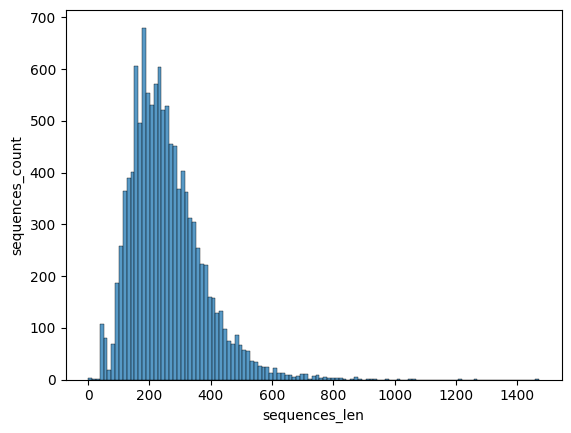

1472


In [12]:
tokens_list = []
for text in replace_finding_lst_v2:
    tokens = tokenizer.encode(text, max_length=512)
    tokens_list.append(tokens)

tokens_len = []
for text_len in replace_finding_lst_v2:
    tokens_len.append(len(text_len))

sns.histplot(data=tokens_len)
plt.xlabel('sequences_len')
plt.ylabel('sequences_count')
plt.show()

cnt = 0
for data in tokens_len:
    if data > 1500:
        cnt += 1
print(max(tokens_len))

### 입력값 확인

In [13]:
# 패딩 진행 = prepadding

max_len = 1472

tokens_list_padded = pad_sequences(tokens_list, padding="pre", maxlen=max_len)

input_value = tokens_list_padded

label = merge_data_frame['Finding']

print("입력 tensor : ", input_value.shape)
print("라벨 tensor : ", label.shape)

입력 tensor :  (11725, 1472)
라벨 tensor :  (11725,)


# 트레인, 검증 셋 분리

In [14]:
seed = 42

input_train, input_test, label_train, label_test = train_test_split(input_value, label, test_size=0.2, random_state=seed)  

print(input_train.shape, input_test.shape, label_train.shape, label_test.shape)

(9380, 1472) (2345, 1472) (9380,) (2345,)


# 파인튜닝
 - 하이퍼밴드 파라미터 튜닝

In [15]:
'''
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from kerastuner.tuners import Hyperband
from tensorflow.keras.optimizers import Adam

adam = Adam(learning_rate=0.001)

def build_model(hp):
    model = medical_LSTM(
        vocab_size=vocab_size,
        embedding_units=hp.Int('embedding_units', min_value=32, max_value=128, step=32),
        lstm_units=hp.Int('lstm_units', min_value=32, max_value=256, step=32),
        dense_input_dim=hp.Int('dense_input_dim', min_value=32, max_value=256, step=32),
        dense_output_dim=1,
        dropout_rate=hp.Float('dropout_rate', min_value=0.3, max_value=0.5, step=0.01),
        l2_reg_rate=hp.Float('l2_reg_rate', min_value=0.001, max_value=0.01, step=0.001)
    )
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    return model

tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=3,
    directory='hyperband',
    project_name='medical_LSTM'
)

tuner.search(input_train, label_train, epochs=3, validation_data=(input_test, label_test))
best_hp = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"embedding 유닛 수 : {best_hp.get('embedding_units')}")
print(f"lstm 유닛 수 : {best_hp.get('lstm_units')}")
print(f"완전 밀집층 차원 수 : {best_hp.get('dense_input_dim')}")
print(f"dropout_rate : {best_hp.get('dropout_rate')}")
print(f"l2_reg_rate : {best_hp.get('l2_reg_rate')}")
'''

'\nfrom tensorflow.keras import layers\nfrom tensorflow.keras.wrappers.scikit_learn import KerasClassifier\nfrom kerastuner.tuners import Hyperband\nfrom tensorflow.keras.optimizers import Adam\n\nadam = Adam(learning_rate=0.001)\n\ndef build_model(hp):\n    model = medical_LSTM(\n        vocab_size=vocab_size,\n        embedding_units=hp.Int(\'embedding_units\', min_value=32, max_value=128, step=32),\n        lstm_units=hp.Int(\'lstm_units\', min_value=32, max_value=256, step=32),\n        dense_input_dim=hp.Int(\'dense_input_dim\', min_value=32, max_value=256, step=32),\n        dense_output_dim=1,\n        dropout_rate=hp.Float(\'dropout_rate\', min_value=0.3, max_value=0.5, step=0.01),\n        l2_reg_rate=hp.Float(\'l2_reg_rate\', min_value=0.001, max_value=0.01, step=0.001)\n    )\n    model.compile(optimizer=adam, loss=\'binary_crossentropy\', metrics=[\'accuracy\'])\n    return model\n\ntuner = Hyperband(\n    build_model,\n    objective=\'val_accuracy\',\n    max_epochs=3,\n  

#### 단방향 lstm 모델 

In [16]:
class sub_lstm(tf.keras.Model):
    def __init__(self, vocab_size, embedding_units, lstm_units):
        super(sub_lstm, self).__init__()

        self.embedding_layer = Embedding(vocab_size, embedding_units)

        self.lstm_layer = LSTM(lstm_units)

        self.output_layer = Dense(1, activation='sigmoid')

    def call(self, inputs):

        inputs = tf.cast(inputs, dtype=tf.float32)

        x = self.embedding_layer(inputs)

        x = self.lstm_layer(x)

        outputs = self.output_layer(x)

        return outputs            

#### 모델 빌드 및 구조

In [28]:
from tensorflow.keras.optimizers import Adam

adam = Adam(learning_rate=0.01)

embedding_units = 96
lstm_units = 32

sub_model = sub_lstm(
    vocab_size= vocab_size,
    embedding_units= embedding_units,
    lstm_units= lstm_units
)

sub_model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
sub_model.build(input_shape=input_train.shape)
sub_model.summary()

Model: "sub_lstm_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     multiple                  2783616   
                                                                 
 lstm_2 (LSTM)               multiple                  16512     
                                                                 
 lstm_3 (LSTM)               multiple                  8320      
                                                                 
 dense_1 (Dense)             multiple                  33        
                                                                 
Total params: 2,808,481
Trainable params: 2,808,481
Non-trainable params: 0
_________________________________________________________________


#### 모델 훈련 

In [29]:
from tensorflow.keras.callbacks import EarlyStopping

earlystop = EarlyStopping(monitor='val_loss', patience=3)
sub_model.fit(x = input_train, 
              y = label_train,
              validation_data=(input_test, label_test),
              epochs=20)

Epoch 1/20
 22/294 [=>............................] - ETA: 9:00 - loss: 0.6951 - accuracy: 0.5483

KeyboardInterrupt: 

# 양방향 LSTM 모델 클래스 정의
 - 참고 레퍼런스 https://keras.io/api/layers/recurrent_layers/lstm/

In [19]:
class medical_LSTM(tf.keras.Model):
    def __init__(self, vocab_size, embedding_units, lstm_units):
        super(medical_LSTM, self).__init__()

        self.embedding_layer = Embedding(vocab_size, embedding_units)

        self.first_lstm = Bidirectional(LSTM(lstm_units))

        self.first_dense = Dense(1, activation='sigmoid')
    
    def call(self, inputs):

        inputs = tf.cast(inputs, dtype=tf.float32)

        embedding_output = self.embedding_layer(inputs)

        first_lstm_output = self.first_lstm(embedding_output)

        first_dense_outputs = self.first_dense(first_lstm_output)

        return first_dense_outputs       

# 모델 컴파일
 - 최적화 도구 adam learning_rate = 0.01
 - 콜백함수 레퍼런스 : https://deep-deep-deep.tistory.com/1 

In [20]:
lstm_units = 256
word_size = tokenizer.vocab_size
final_output_dim = 1

model = medical_LSTM(
            vocab_size = word_size,
            embedding_units= embedding_units,
            lstm_units = lstm_units)

model.compile(optimizer = adam, loss='binary_crossentropy', metrics=['accuracy'])

# 모델 요약

In [21]:
model.build(input_shape=(input_train.shape))
model.summary()

Model: "medical_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     multiple                  2783616   
                                                                 
 bidirectional (Bidirectiona  multiple                 722944    
 l)                                                              
                                                                 
 dense_1 (Dense)             multiple                  513       
                                                                 
Total params: 3,507,073
Trainable params: 3,507,073
Non-trainable params: 0
_________________________________________________________________


# 모델 학습

In [22]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',patience=4)

record = model.fit(
    input_train,
    label_train,
    epochs = 50,
    validation_split = 0.2
)

Epoch 1/50
235/235 [==============================] - 35s 140ms/step - loss: 0.8989 - accuracy: 0.5848 - val_loss: 0.6477 - val_accuracy: 0.6343
Epoch 2/50
235/235 [==============================] - 32s 137ms/step - loss: 0.7015 - accuracy: 0.5953 - val_loss: 0.6520 - val_accuracy: 0.6290
Epoch 3/50
235/235 [==============================] - 32s 138ms/step - loss: 0.6949 - accuracy: 0.6062 - val_loss: 0.7506 - val_accuracy: 0.5618
Epoch 4/50
235/235 [==============================] - 34s 146ms/step - loss: 0.6896 - accuracy: 0.6057 - val_loss: 0.6667 - val_accuracy: 0.6226
Epoch 5/50
235/235 [==============================] - 33s 140ms/step - loss: 0.6630 - accuracy: 0.6259 - val_loss: 0.6527 - val_accuracy: 0.6423
Epoch 6/50
235/235 [==============================] - 33s 141ms/step - loss: 0.6640 - accuracy: 0.6254 - val_loss: 0.6575 - val_accuracy: 0.6130
Epoch 7/50
235/235 [==============================] - 33s 139ms/step - loss: 0.6878 - accuracy: 0.6059 - val_loss: 0.6746 - val_ac

KeyboardInterrupt: 